<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/densenet_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dense networks

We implement DenseNet.
Based on 7.7 of http://d2l.ai/chapter_convolutional-modern/densenet.html



In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(seed=1)
import math

import torch
from torch import nn
from torch.nn import functional as F

!mkdir figures # for saving plots

!wget https://raw.githubusercontent.com/d2l-ai/d2l-en/master/d2l/torch.py -q -O d2l.py
import d2l

# Dense blocks

A conv block uses BN-activation-conv in order.

In [3]:
def conv_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1))

A DenseBlock is a sequence of conv-blocks, each consuming as input all previous outputs.

In [4]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, input_channels, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(
                conv_block(num_channels * i + input_channels, num_channels))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # Concatenate the input and output of each block on the channel
            # dimension
            X = torch.cat((X, Y), dim=1)
        return X

Example: we start with 3 channels, make a DenseBlock with 2 conv-blocks each with 10 channels, to get an output with 23 channels.

In [5]:
blk = DenseBlock(2, 3, 10)
X = torch.randn(4, 3, 8, 8)
Y = blk(X)
Y.shape

torch.Size([4, 23, 8, 8])

# Transition layers

To prevent the number of channels exploding, we can add a transition layer, that uses 1x1 convolution. We can also reduce the spatial resolution using stride 2 average pooling.

In [7]:
def transition_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2))

Below we show an example where we map the 23 channels back down to 10, and halve the spatial dimensions.

In [8]:
blk = transition_block(23, 10)
blk(Y).shape

torch.Size([4, 10, 4, 4])

# Full model

The first part of the model is similar to resnet.

In [22]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

The "backbone" is 4 dense-blocks, each of which has 4 conv-blocks with 32 channels. Since the number of channels increases for each conv-block, the parameter 32 is called the "growth rate". We insert a transition block between each dense-block to keep things from getting too large. 

In [23]:
# `num_channels`: the current number of channels
num_channels = 64 # output of first part of model
growth_rate = 32
num_convs_in_dense_blocks = [4, 4, 4, 4]
blks = []
for i, num_convs in enumerate(num_convs_in_dense_blocks):
    blks.append(DenseBlock(num_convs, num_channels, growth_rate))
    # This is the number of output channels in the previous dense block
    num_channels += num_convs * growth_rate
    # A transition layer that halves the number of channels is added between
    # the dense blocks
    if i != len(num_convs_in_dense_blocks) - 1:
        blks.append(transition_block(num_channels, num_channels // 2))
        num_channels = num_channels // 2

Finally we add average pooling and an FC layer. We assume 10 classes, for MNIST.

In [24]:
net = nn.Sequential(b1, *blks, nn.BatchNorm2d(num_channels), nn.ReLU(),
                    nn.AdaptiveMaxPool2d((1, 1)), nn.Flatten(),
                    nn.Linear(num_channels, 10))

In [25]:
net

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): DenseBlock(
    (net): Sequential(
      (0): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (2): Sequential(
        (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
        (2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

In [27]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
DenseBlock output shape:	 torch.Size([1, 192, 56, 56])
Sequential output shape:	 torch.Size([1, 96, 28, 28])
DenseBlock output shape:	 torch.Size([1, 224, 28, 28])
Sequential output shape:	 torch.Size([1, 112, 14, 14])
DenseBlock output shape:	 torch.Size([1, 240, 14, 14])
Sequential output shape:	 torch.Size([1, 120, 7, 7])
DenseBlock output shape:	 torch.Size([1, 248, 7, 7])
BatchNorm2d output shape:	 torch.Size([1, 248, 7, 7])
ReLU output shape:	 torch.Size([1, 248, 7, 7])
AdaptiveMaxPool2d output shape:	 torch.Size([1, 248, 1, 1])
Flatten output shape:	 torch.Size([1, 248])
Linear output shape:	 torch.Size([1, 10])


In [26]:
X = torch.rand(size=(1, 1, 96, 96))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
DenseBlock output shape:	 torch.Size([1, 192, 24, 24])
Sequential output shape:	 torch.Size([1, 96, 12, 12])
DenseBlock output shape:	 torch.Size([1, 224, 12, 12])
Sequential output shape:	 torch.Size([1, 112, 6, 6])
DenseBlock output shape:	 torch.Size([1, 240, 6, 6])
Sequential output shape:	 torch.Size([1, 120, 3, 3])
DenseBlock output shape:	 torch.Size([1, 248, 3, 3])
BatchNorm2d output shape:	 torch.Size([1, 248, 3, 3])
ReLU output shape:	 torch.Size([1, 248, 3, 3])
AdaptiveMaxPool2d output shape:	 torch.Size([1, 248, 1, 1])
Flatten output shape:	 torch.Size([1, 248])
Linear output shape:	 torch.Size([1, 10])


# Training

We fit the model to Fashion-MNIST. We rescale images from 28x28 to 96x96, so that the input to the final average pooling layer has size 3x3. We notice that the training speed is much less than for ResNet.

loss 0.149, train acc 0.945, test acc 0.849
3350.3 examples/sec on cuda:0


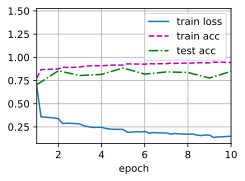

In [13]:
lr, num_epochs, batch_size = 0.1, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())